In [38]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
          self.grad += 1.0 * out.grad
          other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
      return self * other

    def __pow__(self, other):
      assert isinstance(other, (int, float))
      out = Value(self.data**other, (self, ), f"**{other}")
      def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
      out._backward = _backward
      return out

    def __truediv__(self, other):
      other = other if isinstance(other, Value) else Value(other)
      return self * (other ** -1)


    def tanh(self):
      x = self.data
      t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
      out = Value(t, (self, ), 'tanh')
      def _backward():
        self.grad += (1-t**2) * out.grad
      out._backward = _backward
      return out

    def exp(self):
      x = self.data
      out = Value(math.exp(x), (self, ), 'exp')
      def _backward():
        self.grad += out.data * out.grad
      out._backward = _backward
      return out

    def backward(self):

      topo = []
      visited = set()
      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)
      build_topo(self)

      self.grad = 1.0
      for node in reversed(topo):
        node._backward()

In [40]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in getattr(v, "_prev", []):
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label= "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')

        if getattr(n, "_op", None):
            opid = uid + n._op
            dot.node(name=opid, label=n._op)
            dot.edge(opid, uid)

    for n1, n2 in edges:
        if getattr(n2, "_op", None):
            dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [41]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)
    return params

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [42]:
def optimize(model, xs, ys, epochs, lr):
    for k in range(epochs):
        ypred = [model(x) for x in xs]
        loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

        for p in model.parameters():
            p.grad = 0.0

        loss.backward()

        for p in model.parameters():
            p.data += -lr * p.grad

        print(k, loss.data)

In [47]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.8682149672053633),
 Value(data=-0.81214651124563),
 Value(data=-0.9086598035241654),
 Value(data=0.8393017292539906)]

In [49]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=0.0868231938188735)

In [50]:
loss.backward()

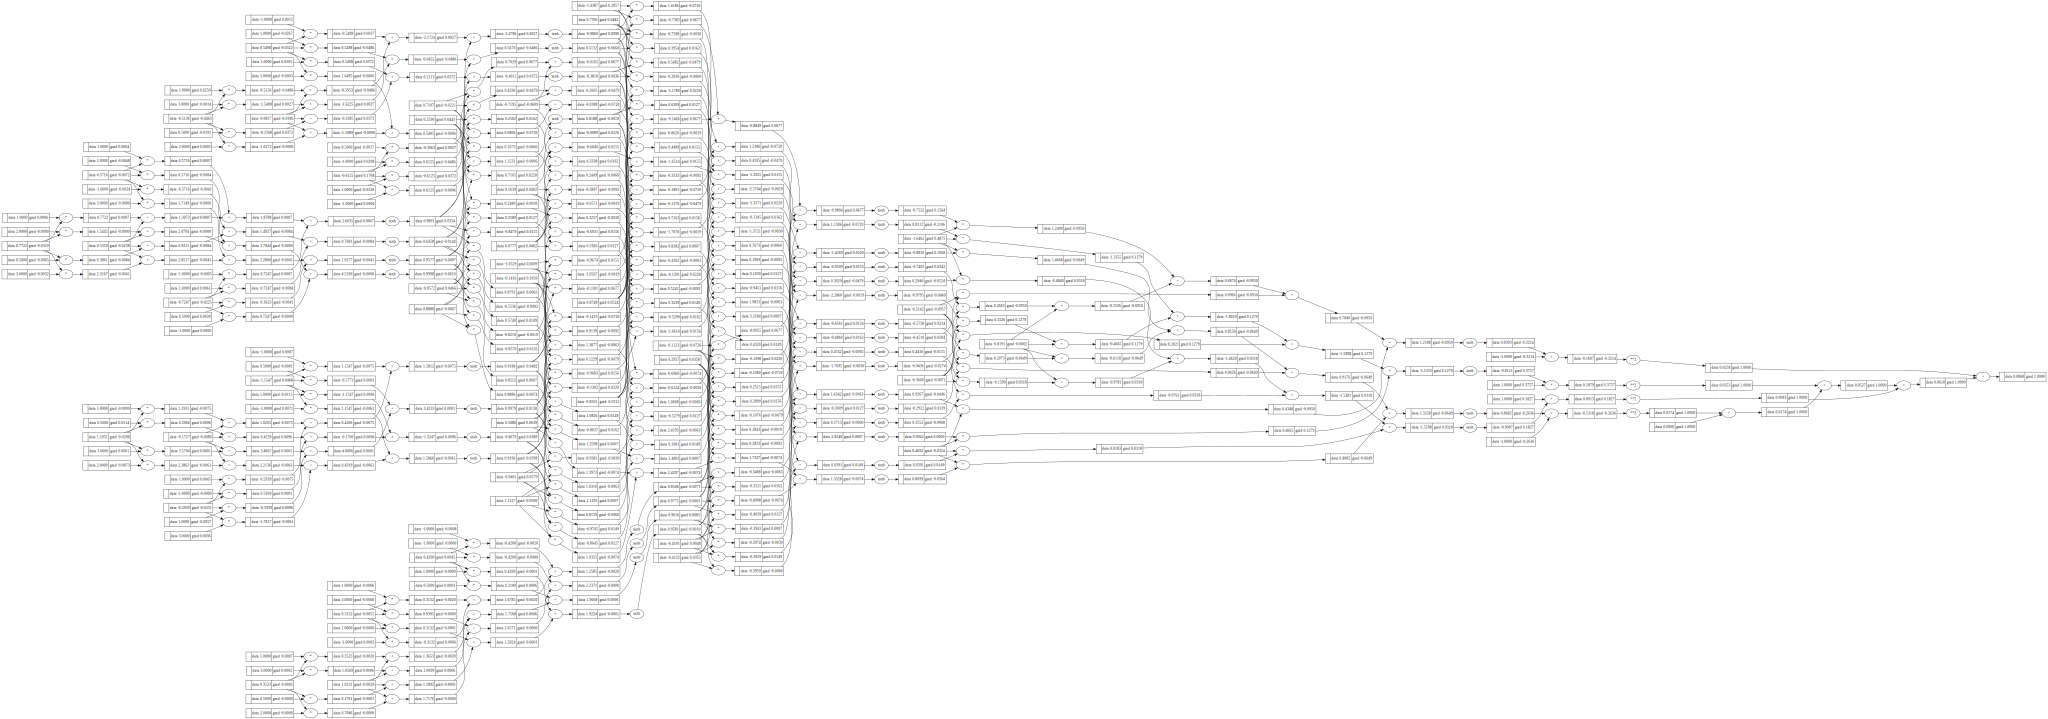

In [51]:
draw_dot(loss)

In [65]:
optimize(n, xs, ys, epochs=10, lr=0.01)

0 0.04983446054739206
1 0.04947442521794158
2 0.04911934111463043
3 0.048769109299120116
4 0.048423633405461804
5 0.048082819558192116
6 0.047746576293502596
7 0.047414814483349485
8 0.04708744726237876
9 0.046764389957546296


In [66]:
ypred

[Value(data=0.8682149672053633),
 Value(data=-0.81214651124563),
 Value(data=-0.9086598035241654),
 Value(data=0.8393017292539906)]